<a href="https://colab.research.google.com/github/nileshrathod17/Online-Retail-Customer-Segmentation/blob/main/Online_Retail_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Segmentation for Online Retail store**
We endeavour to find the various customer segments using the online retail store's transaction data obtained from UCI Machine Learning Dataset repository. This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

# **The need of customer segmentation:**
The differences in customers' behaviour, demographics, geographies, etc. help in classifying them in groups. Learning about different groups in the customer can help with following:

Target Marketing               

Client understanding

Optimal product placement

Searching for new customers

Revenue growth




# **Recency-Frequency-Monetary (RFM) model to determine customer value:**
The RFM model is quite useful model in retail customer segmentation where only the data of customer transaction is available. RFM stands for the three dimensions:

Recency – How recently did the customer purchase?

Frequency – How often do they purchase?

Monetary Value – How much do they spend?

A combination of these three attributes can be defined to assign a quantitative value to customers. e.g. A customer who recently bought high value products and transacts regularly is a high value customer.

# **Import Libraries and Data**

In [14]:
# Import libraries
import pandas as pd
import datetime as dt
import numpy as np
import re
# import libraries
import pandas  as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import collections
from collections import Counter
from collections import defaultdict
import itertools

from scipy import stats
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [15]:
# Mount your drive and read the csv file. Make sure you are using the correct file path
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Online Retail Customer Segmentation/Online Retail.xlsx'
data=pd.read_excel(file_path)

In [28]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# **Attribute Information**

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name. Nominal.

Quantity: The quantities of each product (item) per transaction. Numeric.

InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated.

UnitPrice: Unit price. Numeric, Product price per unit in sterling.

CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

Country: Country name. Nominal, the name of the country where each customer resides.

In [20]:
data.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [29]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# **Initial Findings**

**Potential data reversal.**

The max and min value of Quantity are both 80995; it could represent a reversal of data entry. However, the issue is that both the initial and reversal entry are retained in the dataset. Further investigation is needed to understand the nature and determine the best way to manage such data reversal.
**Potential indication of cancellation orders from negative UnitPrice.**

It is uncommon to have negative UnitPrice, as this would mean a cash outflow to a company. These transactions could represent cancelled orders by customers or bad-debt/write-off incurred by the business.

**Missing 25% of CustomerID.**

The missing unique identified of customers could post a problem as market/customer segmentation requires grouping each unique customer into a group.

# **Data Pre-Processing and Feature Engineering**

# **InvoiceDate**

**Separate Date and Time information from InvoiceDate**

The InvoiceDate column contains both date and time of the transaction. These data are separated into individual columns to facilitate future feature engineering and data manipulation.

In [31]:
# Split datetime from InvoiceDate
data['Date'] = data['InvoiceDate'].dt.date
#df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
data['Time'] = data['InvoiceDate'].dt.time
# Remove InvoiceDate column
data.drop(['InvoiceDate'], axis=1, inplace=True)
data.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00


# **InvoiceNo**
**Extract transaction status from InvoiceNo**

InvoiceNo contains both transaction status (i.e. having a 'C' denotes cancelled transaction) and transaction identifier (e.g. unique invoice number). This information could be extracted to facilitate further feature engineering.

In [34]:
# Separate order status and invoice number from InvoiceNo
data['CancelledOrder'] = data['InvoiceNo'].apply(
    lambda x: re.findall(r'[A-Z]', str(x))).apply(lambda x: pd.Series(x))
data['Invoice_No'] = data['InvoiceNo'].apply(
    lambda x: re.findall(r'\d+', str(x))).apply(lambda x: pd.Series(x))

# Remove old InvoiceNo column
data.drop(['InvoiceNo'], axis=1, inplace=True)

data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,NaN,536365
1,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,NaN,536365
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,NaN,536365
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,NaN,536365
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,NaN,536365


In [36]:
# Encode CancelledOrder
data['CancelledOrder'] = data['CancelledOrder'].astype('category')
data['CancelledOrder'].unique()

[NaN, 'C', 'A']
Categories (2, object): ['A', 'C']

In [37]:
def filter_row(data, column, criterion, operator='equal'):
    '''
    Filter rows based on specific condition
    '''
    if operator == 'equal':
        return data[data[column] == criterion]
    if operator == 'less':
        return data[data[column] <= criterion]
    if operator == 'more':
        return data[data[column] >= criterion]

def remove_row(data, column, criterion):
    '''
    Remove ros based on specific condition
    '''
    return data[data[column] != criterion]

In [38]:
# 'A' category is unexpected; printing out rows to investigate further
filter_row(data, 'CancelledOrder', 'A')

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No
299982,B,Adjust bad debt,1,11062.06,NaN,United Kingdom,2011-08-12,14:50:00,A,563185
299983,B,Adjust bad debt,1,-11062.06,NaN,United Kingdom,2011-08-12,14:51:00,A,563186
299984,B,Adjust bad debt,1,-11062.06,NaN,United Kingdom,2011-08-12,14:52:00,A,563187


# **Drop Bad Debt Records**

Bad debt adjustments are dropped from the dataset as these do not represent actual sales. Furthermore, they are not tagged to any specific customer.

In [39]:
# Drop Bad Debt Record
data = remove_row(data, 'CancelledOrder', 'A')

# Encode column
data['CancelledOrder'] = data['CancelledOrder'].cat.add_categories([0])
data['CancelledOrder'].fillna(value=0, inplace=True)
data['CancelledOrder'].replace(to_replace='C', value=1, inplace=True)

data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retu

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365
1,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365


In [41]:
data.nunique()

StockCode          4069
Description        4222
Quantity            722
UnitPrice          1628
CustomerID         4372
Country              38
Date                305
Time                774
CancelledOrder        2
Invoice_No        25897
dtype: int64

# **Observation**
**StockCode as Categorical Data**

StockCode is a unique identifier assigned to each item and the StockCode should be a category dtype.
Given the number of items, performing One Hot Encoding might not be feasible as this might result in 'curse of dimensionality'. This column will be one-hot encoded at a later stage should the need arise.

In [43]:
data['StockCode'] = data.StockCode.astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541906 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   StockCode       541906 non-null  category
 1   Description     540452 non-null  object  
 2   Quantity        541906 non-null  int64   
 3   UnitPrice       541906 non-null  float64 
 4   CustomerID      406829 non-null  float64 
 5   Country         541906 non-null  object  
 6   Date            541906 non-null  object  
 7   Time            541906 non-null  object  
 8   CancelledOrder  541906 non-null  category
 9   Invoice_No      541906 non-null  object  
dtypes: category(2), float64(2), int64(1), object(5)
memory usage: 38.9+ MB


# **Unit Price**

# **Total spending of customers could be derived for additional datapoint**

The unit price represents the price of a single item; a new column ('TotalSum') could be created to represent the total price paid by the customer for the respective purchase.

In [44]:
data['TotalSum'] = data['Quantity'] * data['UnitPrice']
data.describe()

,Quantity,UnitPrice,CustomerID,TotalSum
count,541906.000000,541906.000000,406829.000000,541906.000000
mean,9.552297,4.631552,15287.690570,18.008308
std,218.081761,93.192775,1713.600303,377.915677
min,-80995.000000,0.000000,12346.000000,-168469.600000
25%,1.000000,1.250000,13953.000000,3.400000
50%,3.000000,2.080000,15152.000000,9.750000
75%,10.000000,4.130000,16791.000000,17.400000
max,80995.000000,38970.000000,18287.000000,168469.600000


In [45]:
# View rows with 0 TotalSum
filter_row(data, 'TotalSum', 0).head()

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum
622,22139,NaN,56,0.0,NaN,United Kingdom,2010-12-01,11:52:00,0,536414,0.0
1970,21134,NaN,1,0.0,NaN,United Kingdom,2010-12-01,14:32:00,0,536545,0.0
1971,22145,NaN,1,0.0,NaN,United Kingdom,2010-12-01,14:33:00,0,536546,0.0
1972,37509,NaN,1,0.0,NaN,United Kingdom,2010-12-01,14:33:00,0,536547,0.0
1987,85226A,NaN,1,0.0,NaN,United Kingdom,2010-12-01,14:34:00,0,536549,0.0


# **Removing rows with 0 TotalSum**

(DISCUSSION) Rows with 0 TotalSum seems to serve as recording for misc activities; further discussion with business analysts is needed to understand the nature of such data. Pending such, these rows are removed.

In [46]:
data = remove_row(data, 'TotalSum', 0)
data.describe()

,Quantity,UnitPrice,CustomerID,TotalSum
count,539391.000000,539391.000000,406789.000000,539391.000000
mean,9.845921,4.653148,15287.795830,18.092274
std,215.412851,93.409248,1713.573064,378.793696
min,-80995.000000,0.001000,12346.000000,-168469.600000
25%,1.000000,1.250000,13954.000000,3.750000
50%,3.000000,2.080000,15152.000000,9.840000
75%,10.000000,4.130000,16791.000000,17.400000
max,80995.000000,38970.000000,18287.000000,168469.600000


In [47]:
# View rows with 0 TotalSum
filter_row(data, 'TotalSum', 0, 'less')

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum
141,D,Discount,-1,27.50,14527.0,United Kingdom,2010-12-01,09:41:00,1,536379,-27.50
154,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,15311.0,United Kingdom,2010-12-01,09:49:00,1,536383,-4.65
235,22556,PLASTERS IN TIN CIRCUS PARADE,-12,1.65,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-19.80
236,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-6.96
237,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-6.96
...,...,...,...,...,...,...,...,...,...,...,...
540449,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,0.83,14397.0,United Kingdom,2011-12-09,09:57:00,1,581490,-9.13
541541,M,Manual,-1,224.69,15498.0,United Kingdom,2011-12-09,10:28:00,1,581499,-224.69
541715,21258,VICTORIAN SEWING BOX LARGE,-5,10.95,15311.0,United Kingdom,2011-12-09,11:57:00,1,581568,-54.75
541716,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,1.25,17315.0,United Kingdom,2011-12-09,11:58:00,1,581569,-1.25


In [48]:
# Check if any TotalSum with less than 0 do not belong to cancelled order
data[data['TotalSum'] <= 0][data['CancelledOrder'] == 0].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum


# **Negative TotalSum is due to negative quantity**

Negative TotalSum is caused by negative quantity. Further investigation will be made later for such negative quantity.

# **Description**

In [49]:
# Print description list
print(data['Description'].unique())

print('\n Number of unique items: {}'.format(data['Description'].nunique()))

['WHITE HANGING HEART T-LIGHT HOLDER' 'WHITE METAL LANTERN'
 'CREAM CUPID HEARTS COAT HANGER' ... 'LETTER "U" BLING KEY RING'
 'CREAM HANGING HEART T-LIGHT HOLDER' 'PAPER CRAFT , LITTLE BIRDIE']

 Number of unique items: 4041


# **Description could harbour irrelevant data**

Description describes the items/activities. The list of items could potentially other non-relevant data for customer segmentation. Such irrelevant item/activities will be removed at second iteration of data-preprocessing or feature engineering, if necessary.

# **Quantity**

In [50]:
# Check for rows with negative quantity
filter_row(data, 'Quantity', 0, 'less')

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum
141,D,Discount,-1,27.50,14527.0,United Kingdom,2010-12-01,09:41:00,1,536379,-27.50
154,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,15311.0,United Kingdom,2010-12-01,09:49:00,1,536383,-4.65
235,22556,PLASTERS IN TIN CIRCUS PARADE,-12,1.65,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-19.80
236,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-6.96
237,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-6.96
...,...,...,...,...,...,...,...,...,...,...,...
540449,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,0.83,14397.0,United Kingdom,2011-12-09,09:57:00,1,581490,-9.13
541541,M,Manual,-1,224.69,15498.0,United Kingdom,2011-12-09,10:28:00,1,581499,-224.69
541715,21258,VICTORIAN SEWING BOX LARGE,-5,10.95,15311.0,United Kingdom,2011-12-09,11:57:00,1,581568,-54.75
541716,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,1.25,17315.0,United Kingdom,2011-12-09,11:58:00,1,581569,-1.25


# **Negative quantity denotes cancelled transaction**

It appears that negative quantity represents the cancelled transaction. However, the exact reason for the cancellation is not known.

There are two ways to manage the cancelled orders:

Account for both corresponding initial orders and cancelled orders to remove sales from the dataset, since there is no actual profit made from the cancelled orders.

Drop only the cancelled orders to maximise customers' data, though it will also capture the wrong purchase made by customers.

(DISCUSSION) The first approach will reflect the actual purchase made, as cancelled orders could represent wrong order by customers and this doesn't reflect the actual customer's purchase intent. The value of corresponding purchases and the cancelled transaction will be aggregated and hence the rows value will offset each other naturally.

CustomerID

In [51]:
data.describe()

,Quantity,UnitPrice,CustomerID,TotalSum
count,539391.000000,539391.000000,406789.000000,539391.000000
mean,9.845921,4.653148,15287.795830,18.092274
std,215.412851,93.409248,1713.573064,378.793696
min,-80995.000000,0.001000,12346.000000,-168469.600000
25%,1.000000,1.250000,13954.000000,3.750000
50%,3.000000,2.080000,15152.000000,9.840000
75%,10.000000,4.130000,16791.000000,17.400000
max,80995.000000,38970.000000,18287.000000,168469.600000


In [52]:
# Identify rows with missing customerID
data.isnull().sum(axis=0)

StockCode              0
Description            0
Quantity               0
UnitPrice              0
CustomerID        132602
Country                0
Date                   0
Time                   0
CancelledOrder         0
Invoice_No             0
TotalSum               0
dtype: int64

**25% of critical information missing from dataset**

There is a total of 132,602 rows (~25% of total data) with missing information on CustomerID. CustomerID holds the identity of the customer and without which, it will be impossible to perform customer segmentation.

**Exploring Data Imputation Based on InvoiceNo**

The missing values could be imputed based on other features such as InvoiceNo since the same customer would probably buy for the items under the same invoice.

In [53]:
# Print rows with missing CustomerID
data[data['CustomerID'].isnull()]

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum
1443,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2.51,NaN,United Kingdom,2010-12-01,14:32:00,0,536544,2.51
1444,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2.51,NaN,United Kingdom,2010-12-01,14:32:00,0,536544,5.02
1445,21786,POLKADOT RAIN HAT,4,0.85,NaN,United Kingdom,2010-12-01,14:32:00,0,536544,3.40
1446,21787,RAIN PONCHO RETROSPOT,2,1.66,NaN,United Kingdom,2010-12-01,14:32:00,0,536544,3.32
1447,21790,VINTAGE SNAP CARDS,9,1.66,NaN,United Kingdom,2010-12-01,14:32:00,0,536544,14.94
...,...,...,...,...,...,...,...,...,...,...,...
541536,85099B,JUMBO BAG RED RETROSPOT,5,4.13,NaN,United Kingdom,2011-12-09,10:26:00,0,581498,20.65
541537,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,4.13,NaN,United Kingdom,2011-12-09,10:26:00,0,581498,16.52
541538,85150,LADIES & GENTLEMEN METAL SIGN,1,4.96,NaN,United Kingdom,2011-12-09,10:26:00,0,581498,4.96
541539,85174,S/4 CACTI CANDLES,1,10.79,NaN,United Kingdom,2011-12-09,10:26:00,0,581498,10.79


In [64]:
# Print rows with missing CustomerID with CancelledOrder
#data[data['CustomerID'].isnull() & data['CancelledOrder'] == 1]

# **Business Context**

(ASSUMPTION) Missing CustomerID will be imputed with random numbers that are not existing in the dataset. Since this is an online purchase, these transactions could be made under 'Guest Checkout' which doesn't require the customer to create an account.
(ASSUMPTION) These transactions could likely be a one-time purchase as customers who shop frequently would probably create an account for ease of purchasing and perhaps earn rewards.
# **Rows with missing customerID will be dropped**

(DISCUSSION) As discovered earlier, the corresponding purchase and cancelled transaction do not have same InvoiceNo. Though it is possible to impute CustomerID based on the unique value of InvoiceNo, there will be big inaccuracy in matching cancelled transactions. This could result in issues when the values are summed up to offset each other at a later stage.

In [63]:
data = data[pd.notnull(data['CustomerID'])]
data.describe()

,Quantity,UnitPrice,CustomerID,TotalSum
count,406789.000000,406789.000000,406789.000000,406789.000000
mean,12.028359,3.460811,15287.795830,20.403860
std,247.927842,69.318561,1713.573064,427.612692
min,-80995.000000,0.001000,12346.000000,-168469.600000
25%,2.000000,1.250000,13954.000000,4.200000
50%,5.000000,1.950000,15152.000000,11.100000
75%,12.000000,3.750000,16791.000000,19.500000
max,80995.000000,38970.000000,18287.000000,168469.600000


# **Country**
**Extracting country location**

The long and lat location of respective country could be added to represent the geographical distance between customers (customers residing in countries near each other might have similar purchase behaviour).

In [65]:
# Import country long/lat location from google
country_loc = pd.read_html(
    'https://developers.google.com/public-data/docs/canonical/countries_csv', header=0)

# Convert data to df
country_loc_data = pd.DataFrame(data=country_loc[0])

# Drop country abbreviation
country_loc_data.drop(['country'], axis=1, inplace=True)

# Rename index column
country_loc_data.rename(index=str, columns={'name':'Country'}, inplace=True)

sorted(country_loc_data['Country'].unique())

['Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antarctica',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Bouvet Island',
 'Brazil',
 'British Indian Ocean Territory',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Christmas Island',
 'Cocos [Keeling] Islands',
 'Colombia',
 'Comoros',
 'Congo [DRC]',
 'Congo [Republic]',
 'Cook Islands',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 "Côte d'Ivoire",
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',

In [66]:
# Create a new column to store result of whether all countries in df are present in country_loc_df
data['Exist'] = data['Country'].isin(country_loc_data['Country'])

# Print out countires which are not present in df
data[data['Exist'] == False]['Country'].unique()

array(['EIRE', 'Channel Islands', 'Unspecified', 'USA',
       'European Community', 'RSA'], dtype=object)

# **Handling missing and mismatched country name**

A quick search of Google shows that EIRE is Irish for Ireland and RSA for South Africa. These will be replaced accordingly.

The USA will be replaced with United States; European Community will be replaced with France; the Channel Islands will be replaced with Jersey.

There are 224 rows without country information (Unspecified). This could be problematic to assign the long and lat information. These countries rows will be imputed with the most frequent countries: United Kingdom.

In [67]:
# Replace countries
data.loc[data['Country'] == 'EIRE', 'Country'] = 'Ireland'
data.loc[data['Country'] == 'RSA', 'Country'] = 'South Africa'
data.loc[data['Country'] == 'USA', 'Country'] = 'United States'
data.loc[data['Country'] == 'European Community', 'Country'] = 'France'
data.loc[data['Country'] == 'Channel Islands', 'Country'] = 'Jersey'
data.loc[data['Country'] == 'Unspecified', 'Country'] = 'United Kingdom'

# Drop Exist column created
data = data.drop(columns=['Exist'])

# Combine data together
data = data.merge(country_loc_data, on=['Country', 'Country'])

# Convert country to categorical dtype
data['Country'] = data.Country.astype('category')

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406789 entries, 0 to 406788
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   StockCode       406789 non-null  category
 1   Description     406789 non-null  object  
 2   Quantity        406789 non-null  int64   
 3   UnitPrice       406789 non-null  float64 
 4   CustomerID      406789 non-null  float64 
 5   Country         406789 non-null  category
 6   Date            406789 non-null  object  
 7   Time            406789 non-null  object  
 8   CancelledOrder  406789 non-null  category
 9   Invoice_No      406789 non-null  object  
 10  TotalSum        406789 non-null  float64 
 11  latitude        406789 non-null  float64 
 12  longitude       406789 non-null  float64 
dtypes: category(3), float64(5), int64(1), object(4)
memory usage: 35.8+ MB


# **Cohort Analysis**

**Creating Time Cohorts**

In [69]:
def get_date(x):
    '''
    Prase year and month values

    '''
    return dt.datetime(x.year, x.month, 1)

In [70]:
# Get month information from dataframe
data['InvoiceMonth'] = data['Date'].apply(get_date)
 
data.head()

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum,latitude,longitude,InvoiceMonth
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,15.30,55.378051,-3.435973,2010-12-01
1,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,2010-12-01
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,22.00,55.378051,-3.435973,2010-12-01
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,2010-12-01
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,2010-12-01


In [71]:
# Group each customer based on their ID and select InvoiceMonth value
grouping = data.groupby('CustomerID')['InvoiceMonth']

# Get first month of each customer acqusition
data['CohortMonth'] = grouping.transform('min')

data.head()

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum,latitude,longitude,InvoiceMonth,CohortMonth
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,15.30,55.378051,-3.435973,2010-12-01,2010-12-01
1,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,2010-12-01,2010-12-01
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,22.00,55.378051,-3.435973,2010-12-01,2010-12-01
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,2010-12-01,2010-12-01
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,2010-12-01,2010-12-01


In [72]:
def get_date_int(dataframe, column):
    '''
    Extract year, month, and day values

    '''
    year = dataframe[column].dt.year
    month = dataframe[column].dt.month
    day = dataframe[column].dt.day
    return year, month, day

In [73]:
# Extract year, month, and day from InvoiceMonth and CohortMonth
invoice_year, invoice_month, invoice_day = get_date_int(data, 'InvoiceMonth')
cohort_year, cohort_month, cohort_day = get_date_int(data, 'CohortMonth')

In [74]:
# Calculate the difference between first acqusition and date of each transaction
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
days_diff = invoice_day - cohort_day

In [75]:
# Calculate time offset in months
data['CohortIndex'] = (years_diff * 12 + months_diff + 1)
data.head()

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum,latitude,longitude,InvoiceMonth,CohortMonth,CohortIndex
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,15.30,55.378051,-3.435973,2010-12-01,2010-12-01,1
1,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,2010-12-01,2010-12-01,1
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,22.00,55.378051,-3.435973,2010-12-01,2010-12-01,1
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,2010-12-01,2010-12-01,1
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,2010-12-01,2010-12-01,1


In [76]:
# Count monthly active customers from each cohort
grouping = data.groupby(['CohortMonth', 'CohortIndex'])

# Count the number of customers in each group via nunique of customerID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)

# Reset index
cohort_data = cohort_data.reset_index()

cohort_data.head()

,CohortMonth,CohortIndex,CustomerID
0,2010-12-01,1,948
1,2010-12-01,2,362
2,2010-12-01,3,317
3,2010-12-01,4,367
4,2010-12-01,5,341


In [77]:
# Create a pivot table for customer retention
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05-01,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **Cohort Metrics**

In [78]:
def cohort_avg_value(cohort_grouping, column, decimal=3):

    # Count average value in each cohort
    cohort_data = grouping[column].mean()

    # Reset index of df
    cohort_data = cohort_data.reset_index()

    # Create a pivot table of average customer purchase value
    average_quantity = cohort_data.pivot(
        index='CohortMonth', columns='CohortIndex', values=column)

    # Round figures
    average_quantity = average_quantity.round(decimal)

    return average_quantity

In [79]:
# Store first column as cohort size
cohort_sizes = cohort_counts.iloc[:, 0]

# Calculate percentage of active customers in each cohort
retention = cohort_counts.divide(cohort_sizes, axis=0)

# Convert retention to percentage format
retention = retention.round(3)

In [80]:
# Calculate average unit price per cohort
avg_cohort_price = cohort_avg_value(grouping, 'UnitPrice', 2)

# Calculate the avg quantity of items purchased in each cohort
avg_cohort_quantity = cohort_avg_value(grouping, 'Quantity', 1)

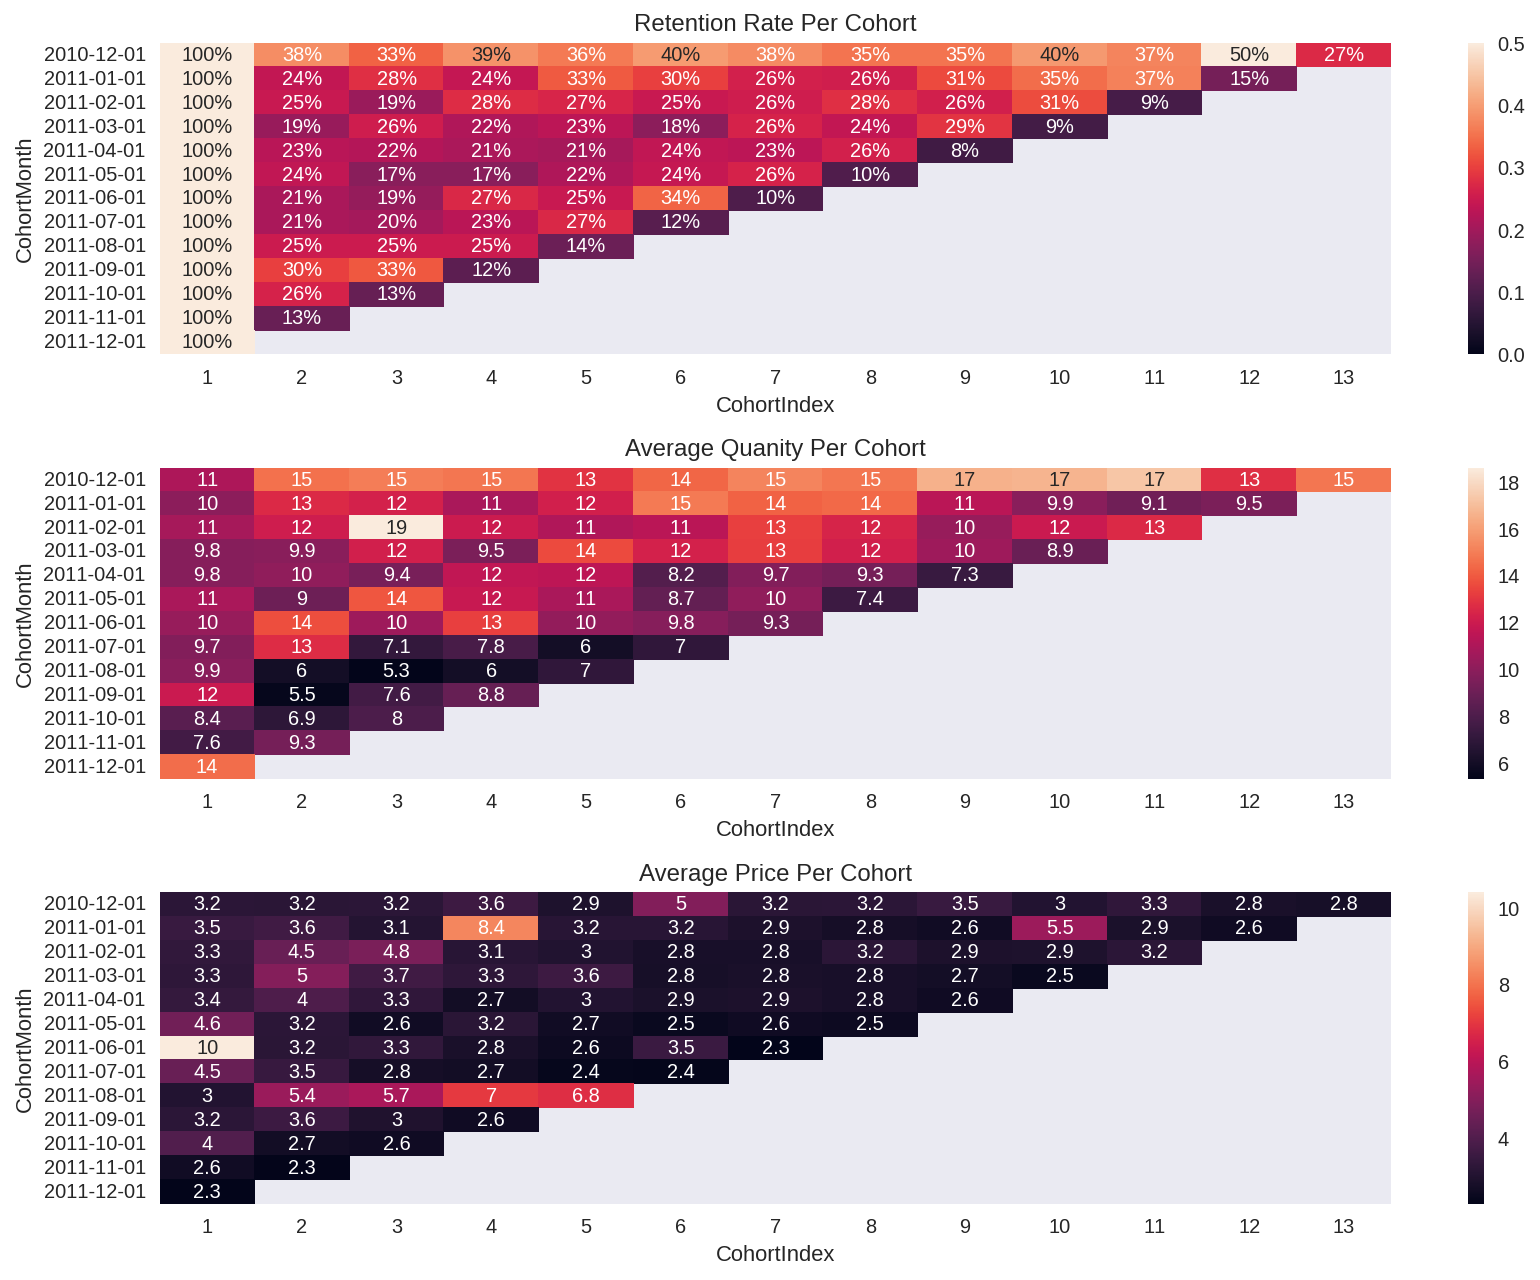

In [81]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
plt.title('Retention Rate Per Cohort')
ax = sns.heatmap(retention, annot=True, fmt='.0%', vmin=0, vmax=0.5)
ax.set_yticklabels(retention.index.date)

plt.subplot(3, 1, 2)
plt.title('Average Quanity Per Cohort')
ax = sns.heatmap(avg_cohort_quantity, annot=True)
ax.set_yticklabels(avg_cohort_quantity.index.date)

plt.subplot(3, 1, 3)
plt.title('Average Price Per Cohort')
ax = sns.heatmap(avg_cohort_price, annot=True)
ax.set_yticklabels(avg_cohort_price.index.date)

plt.tight_layout()

# **Customer retention rate drops over time**

**Customer retention metric measures 2 things:**

How many customers are originally in each cohort (acquisition month)
How many of them are still active in the following months


Approximately 25% of new customers acquired will make a repeat purchase, and this percentage remains fairly consistently barring occasionally increase and dips in activities.

**Quantity of items purchased seems to increase during holiday period**

The number of items purchased remain fairly constant and increased sharply during the holiday period.

**Bigger purchases are made during holiday period**

Customers tend to make a bigger purchase during the holiday period; this could be due to a bigger discount/incentive given.

# **Recency, Frequency, and Monetary (RFM) Segmentation**

RFM is a behavioural customer segmentation for measuring customer value.

**Receny:** How recent was each customer's last purchase

**Frequency:** How many times the customer purchased in the last 12 months

**Monetary Value:** How much has the customer spent in the last 12 months


# **Calculating RFM Values**

In [82]:
# Calculate 1-year date range from latest data
earliest_date = data['Date'].min()
end_date = data['Date'].max()

print("Actual Start Date: {}, Actual End Date: {}".format(earliest_date, end_date))

# Filter 1-year data range from original df
start_date = end_date - pd.to_timedelta(364, unit='d')
data_rfm = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

print("RFM Start Date: {}, RFM End Date: {}".format(
    data_rfm['Date'].min(), data_rfm['Date'].max()))

Actual Start Date: 2010-12-01, Actual End Date: 2011-12-09
RFM Start Date: 2010-12-10, RFM End Date: 2011-12-09


In [83]:
# Create hypothetical snapshot date
snapshot_date = end_date + dt.timedelta(days=1)

# Calculate Recency, Frequency and Monetary value for each customer
data_rfm = data_rfm.groupby(['CustomerID']).agg({
    'Date': lambda x: (snapshot_date - x.max()).days,
    'Invoice_No': 'count',
    'TotalSum': 'sum'})

# Rename the columns
data_rfm.rename(columns={'Date': 'Recency',
                       'Invoice_No': 'Frequency',
                       'TotalSum': 'MonetaryValue'}, inplace=True)

# Print top 5 rows
print(data_rfm.head())

            Recency  Frequency  MonetaryValue
CustomerID                                   
12346.0         326          2           0.00
12347.0           3        151        3598.21
12348.0          76         31        1797.24
12349.0          19         73        1757.55
12350.0         311         17         334.40


**Assigning quantile to each customer**

In [88]:
# Obtain quantile of each customer
def get_quantile(data, column, start_n_quantiles, end_n_quantiles, step=1):

    category_label = range(start_n_quantiles, end_n_quantiles, step)
    
    quantiles = pd.qcut(data[column], q=abs(
        end_n_quantiles - start_n_quantiles), labels=category_label)

    data = data.assign(name=quantiles.values)

    new_column_name = column + '_Q'

    return data.rename(columns={"name": new_column_name})

In [89]:
data_rfm_quantile = data_rfm.copy()

data_rfm_quantile = get_quantile(data_rfm_quantile, 'Recency', 4, 0, -1)
data_rfm_quantile = get_quantile(data_rfm_quantile, 'Frequency', 1, 5)
data_rfm_quantile = get_quantile(data_rfm_quantile, 'MonetaryValue', 1, 5)

data_rfm_quantile.head()

,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,MonetaryValue_Q
CustomerID,,,,,,
12346.0,326,2,0.00,1,1,1
12347.0,3,151,3598.21,4,4,4
12348.0,76,31,1797.24,2,2,4
12349.0,19,73,1757.55,3,3,4
12350.0,311,17,334.40,1,1,2


**Calculate RFM Score**

In [90]:
# Concatenate RFM quartile values
def join_rfm(x): 
    return str(x['Recency_Q']) + str(x['Frequency_Q']) + str(x['MonetaryValue_Q'])

In [92]:
# Form RFM segment
data_rfm_quantile['RFM_Segment'] = data_rfm_quantile.apply(join_rfm, axis=1)

data_rfm_quantile.head()

,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,MonetaryValue_Q,RFM_Segment
CustomerID,,,,,,,
12346.0,326,2,0.00,1,1,1,1.01.01.0
12347.0,3,151,3598.21,4,4,4,4.04.04.0
12348.0,76,31,1797.24,2,2,4,2.02.04.0
12349.0,19,73,1757.55,3,3,4,3.03.04.0
12350.0,311,17,334.40,1,1,2,1.01.02.0


In [93]:
# Calculate RFM_Score
data_rfm_quantile['RFM_Score'] = data_rfm_quantile[['Recency_Q','Frequency_Q','MonetaryValue_Q']].sum(axis=1)

data_rfm_quantile.head()

,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,MonetaryValue_Q,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,2,0.00,1,1,1,1.01.01.0,3
12347.0,3,151,3598.21,4,4,4,4.04.04.0,12
12348.0,76,31,1797.24,2,2,4,2.02.04.0,8
12349.0,19,73,1757.55,3,3,4,3.03.04.0,10
12350.0,311,17,334.40,1,1,2,1.01.02.0,4


**Analysing RFM Table**

In [94]:
data_rfm_quantile.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
4.04.04.0    449
1.01.01.0    391
3.04.04.0    212
1.02.02.0    200
3.03.03.0    174
2.01.01.0    174
2.02.02.0    169
2.03.03.0    157
4.03.03.0    148
3.01.01.0    121
dtype: int64

In [96]:
data_rfm_quantile[data_rfm_quantile['RFM_Segment']=='111'].head()

,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,MonetaryValue_Q,RFM_Segment,RFM_Score
CustomerID,,,,,,,,


In [97]:
 #Summary Metrics per RFM score
data_rfm_quantile.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           247.4       7.9         106.3   391
4           163.9      14.0         221.7   375
5           146.3      20.7         348.7   507
6            87.8      28.4         487.6   460
7            80.6      39.4         726.4   436
8            57.8      54.8         958.9   464
9            44.1      77.4        1351.5   406
10           30.6     112.8        1800.2   437
11           20.4     197.1        4069.6   370
12            6.8     365.0        8612.1   449

# ***Creating Custom Segments***

In [100]:
def segment_me(data):
    if data['RFM_Score'] >= 9:
        return '1.Gold'
    elif (data['RFM_Score'] >= 5) and (data['RFM_Score'] < 9):
        return '2.Silver'
    else:
        return '3.Bronze'


In [101]:
data_rfm_quantile['General_Segment'] = data_rfm_quantile.apply(segment_me, axis=1)

data_rfm_custom_segment = data_rfm_quantile.groupby('General_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

data_rfm_custom_segment

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
1.Gold             25.2     191.0        4036.1  1662
2.Silver           94.5      35.4         622.8  1867
3.Bronze          206.5      10.8         162.8   766

# **Data Pre-Processing for Clustering**

**K-Means assume symmertical distribution of varibles and variables have equal average value and std**.

**If the distribution is not symmetrical**

Log transformation (if all values are positive)

Add the absolute value of the lowest negative value to each observation, and then with a small constant (e.g. 1) to force all variables to be positive

Use a cube root transformation

If the mean and variables are not equal, the variables could be standardised

# **Reducing Skewness**

In [102]:
def check_skew(data, column):
    skew = stats.skew(data[column])
    skewtest = stats.skewtest(data[column])
    plt.title('Distribution of ' + column)
    sns.distplot(data[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Recency's: Skew: 1.2444937290057807, : SkewtestResult(statistic=26.458726592189453, pvalue=2.895613835933345e-154)
Frequency's: Skew: 18.12183686440274, : SkewtestResult(statistic=83.17480537059672, pvalue=0.0)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MonetaryValue's: Skew: 21.459150114865704, : SkewtestResult(statistic=86.8803096289234, pvalue=0.0)


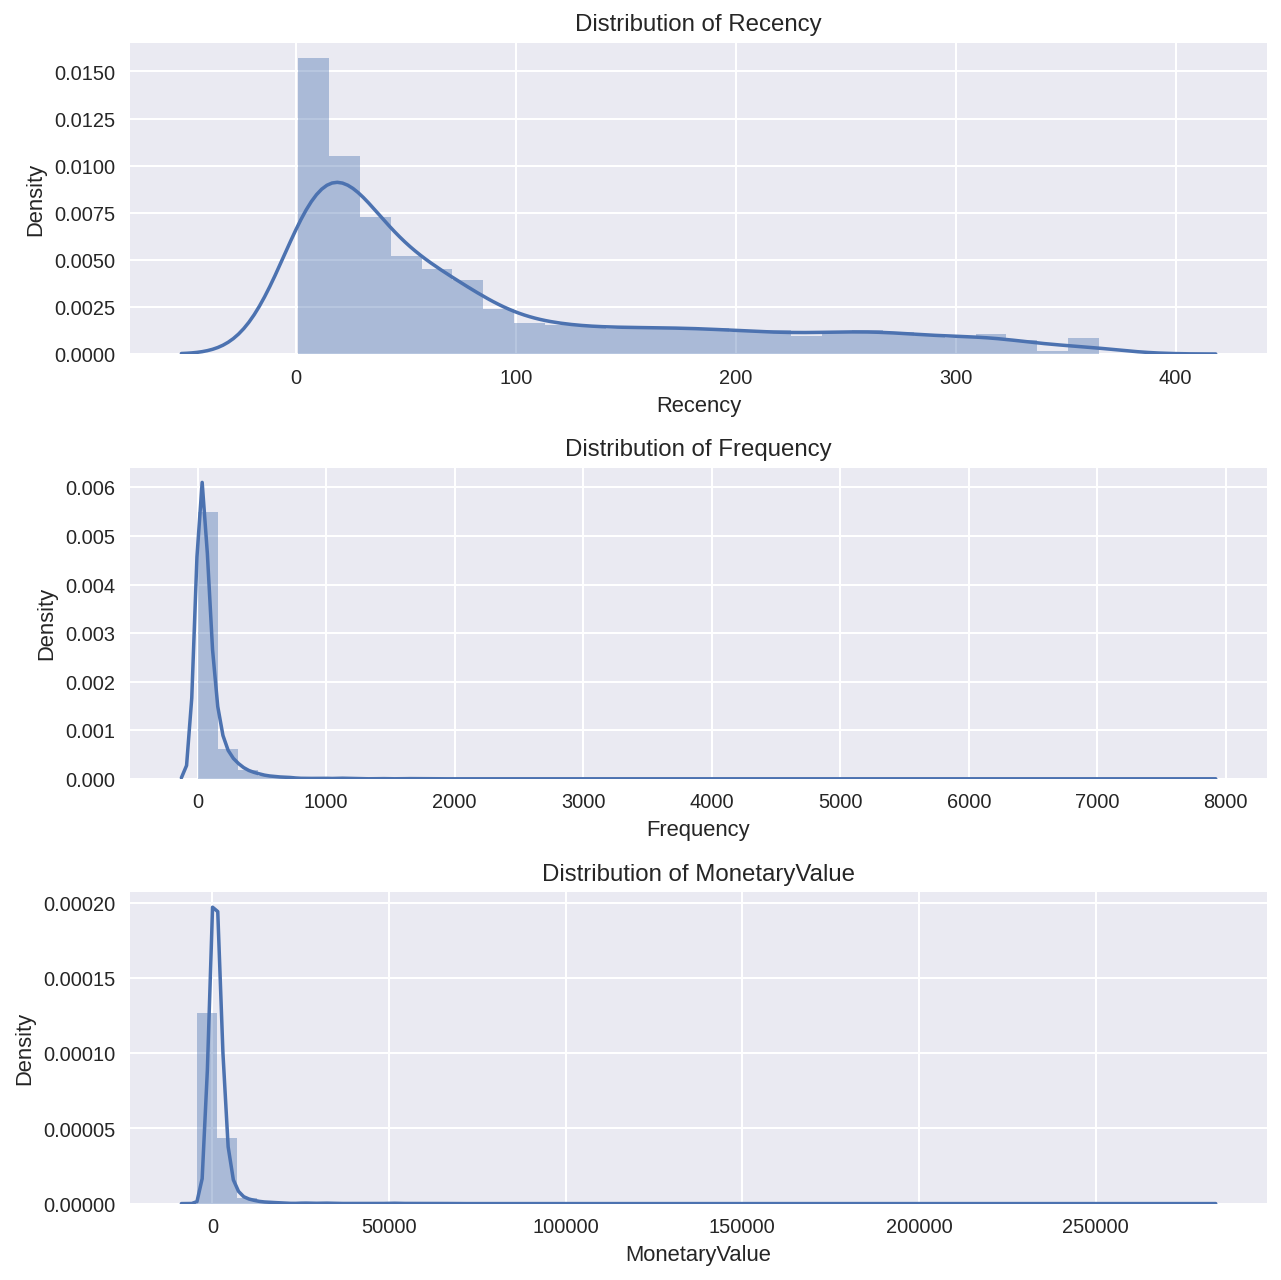

In [103]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(data_rfm,'Recency')

plt.subplot(3, 1, 2)
check_skew(data_rfm,'Frequency')

plt.subplot(3, 1, 3)
check_skew(data_rfm,'MonetaryValue')

plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=1000)

In [104]:
data_rfm.describe()

,Recency,Frequency,MonetaryValue
count,4295.000000,4295.000000,4295.000000
mean,87.682654,91.265891,1861.569840
std,94.578749,227.634841,7996.244601
min,1.000000,1.000000,-4287.630000
25%,17.000000,17.000000,290.260000
50%,48.000000,41.000000,644.240000
75%,134.000000,99.000000,1585.915000
max,365.000000,7793.000000,279489.020000


In [105]:
# Copy original to new df
data_rfm_log = data_rfm.copy()

# Data Pre-Processing for Negative Value
data_rfm_log['MonetaryValue'] = (data_rfm_log['MonetaryValue'] - data_rfm_log['MonetaryValue'].min()) + 1

data_rfm_log.describe()

,Recency,Frequency,MonetaryValue
count,4295.000000,4295.000000,4295.000000
mean,87.682654,91.265891,6150.199840
std,94.578749,227.634841,7996.244601
min,1.000000,1.000000,1.000000
25%,17.000000,17.000000,4578.890000
50%,48.000000,41.000000,4932.870000
75%,134.000000,99.000000,5874.545000
max,365.000000,7793.000000,283777.650000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Recency's: Skew: -0.4547480558293254, : SkewtestResult(statistic=-11.634943795553278, pvalue=2.737704076465579e-31)
Frequency's: Skew: -0.239827897754714, : SkewtestResult(statistic=-6.339202735355403, pvalue=2.309571642177164e-10)
MonetaryValue's: Skew: 0.12898570622951744, : SkewtestResult(statistic=3.4428751888302336, pvalue=0.0005755648779652132)


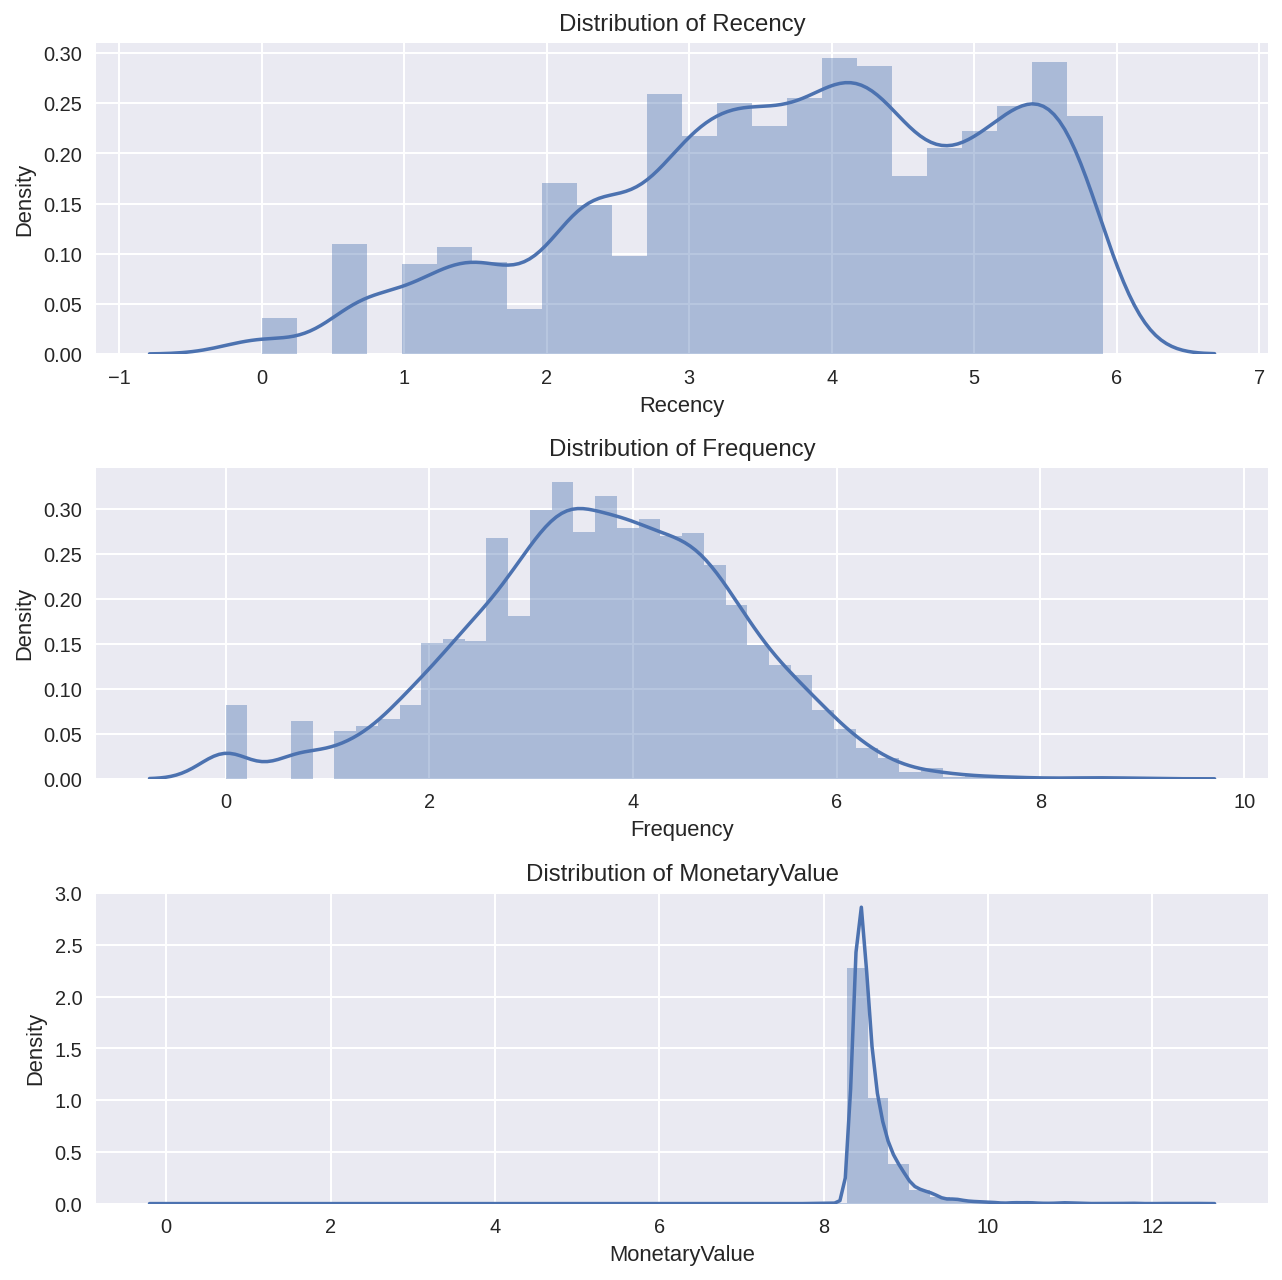

In [106]:
# Transform skewed data with log tranasformation
data_rfm_log = np.log(data_rfm_log)

# Check for skewness after log transformation
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(data_rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(data_rfm_log,'Frequency')

plt.subplot(3, 1, 3)
check_skew(data_rfm_log,'MonetaryValue')

plt.tight_layout()
plt.savefig('after_transform.png', format='png', dpi=1000)

# **Centering and Scaling**

In [107]:
# Scaling data
scaler = StandardScaler()
scaler.fit(data_rfm_log)
data_rfm_normal = scaler.transform(data_rfm_log)

data_rfm_normal = pd.DataFrame(data_rfm_normal, index=data_rfm_log.index, columns=data_rfm_log.columns)

# Check result after standardising
data_rfm_normal.describe().round(3)

,Recency,Frequency,MonetaryValue
count,4295.000,4295.000,4295.000
mean,-0.000,-0.000,-0.000
std,1.000,1.000,1.000
min,-2.672,-2.765,-23.890
25%,-0.643,-0.633,-0.511
50%,0.101,0.029,-0.304
75%,0.836,0.692,0.180
max,1.554,3.977,10.935
